# Time Series Analysis with Bitcoin price

A time series is a series of data points indexed (or listed or graphed) in time order. Time series data should be treated differently to other types of data. 
One of the assumptions of statistical data assumptions is statistical independence. Independence means the value of one observation does not influence or affect the value of other observations.
But in time series data, each data point is close together in time, and they are not completly independent of their adjacent values. So we need a different approach to model time series data.

First, start by loading dependencies. Pandas_datareader is a useful library to extract financial data from web. For this post, I will extract data from Yahoo Finance.

In [1]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

OK, let's get the price data of BTC-USD (Bitcoin value in USD) starting from the start of 2017 to 27/12/2017.

In [2]:
btc = web.get_data_yahoo('BTC-USD', start=datetime.datetime(2017, 1, 1), end=datetime.datetime(2017, 12, 27))

In [3]:
btc.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-01,963.380005,1001.609985,956.099976,995.440002,995.440002,40570922
2017-01-02,995.440002,1031.680054,990.200012,1017.049988,1017.049988,66038073
2017-01-03,1017.049988,1035.469971,1006.530029,1033.300049,1033.300049,56085870
2017-01-04,1033.300049,1148.540039,1022.320007,1135.410034,1135.410034,170584623
2017-01-05,1135.410034,1150.630005,874.530029,989.349976,989.349976,244839289


As you can see, the data has six columns. "Open" for opening price for the day, "High" for the highest price during the day, "Low" for the lowest price during the day, "Close" for closing price for the day, "Adj Close" for adjusted closing price, "Volume" for trasaction volume. In stock price, adjusted closing price reflects a stock's closing price on any given day of trading that has been amended to include any distributions and corporate actions that occurred at any time prior to the next day's open.

But to be 100% honest, I am not sure what factors will be taken into account for the adjusted closing price of a currency, but by looking at the difference of "Close" column, and "Adj Close" column, it seems like they are exactly the same.

In [4]:
np.sum(btc['Close'] - btc['Adj Close'])

0.0

Let's plot "Adj Close" price data on a graph.

In [5]:
btc_adj = btc['Adj Close']

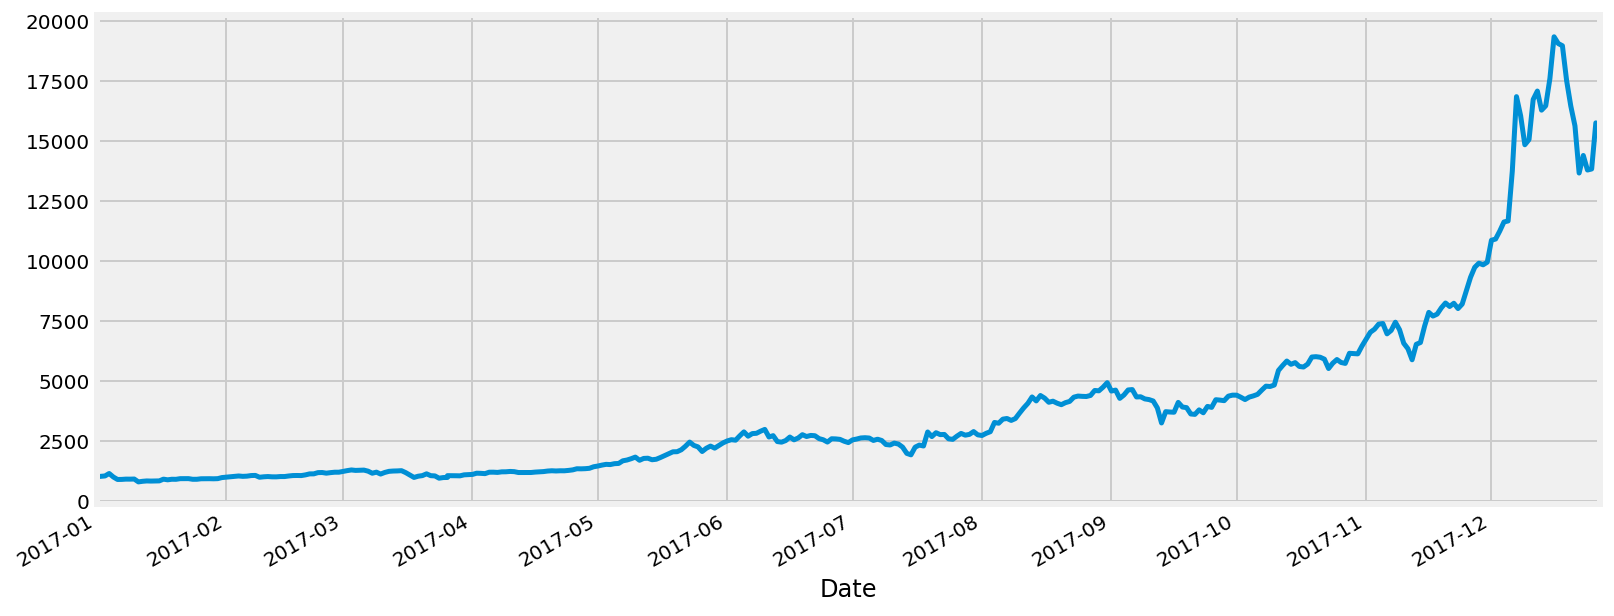

In [6]:
btc_adj.plot(lw=2.5, figsize=(12, 5))
plt.show()

It looks like the USD value of Bitcoin has been steady during the first half of 2017, but started to oscillate and steeply went upward from around November.

## Moving Average

One of the basic analysis technique for time series data is moving average. As the name suggests, rather than calculating the average on the whole dataset, moving average (also called rolling mean) calculates the average of a subset with a certain window size, and shifts forward. Moving average is used to smooth out short-term fluctuations and highlight longer-term trends or cycles. 

Let's see how moving average works on graph by plotting price data from 01/10/2017 to 27/12/2017. I chose the 4th quarter of 2017 to plot where there is a strong trend in the data to clearly see how moving average works.

In [7]:
btc_recent = btc_adj.loc['2017-10-01':'2017-12-27']
rroll_d3 = btc_recent.rolling(window=3).mean()
rroll_d7 = btc_recent.rolling(window=7).mean()
rroll_d14 = btc_recent.rolling(window=14).mean()

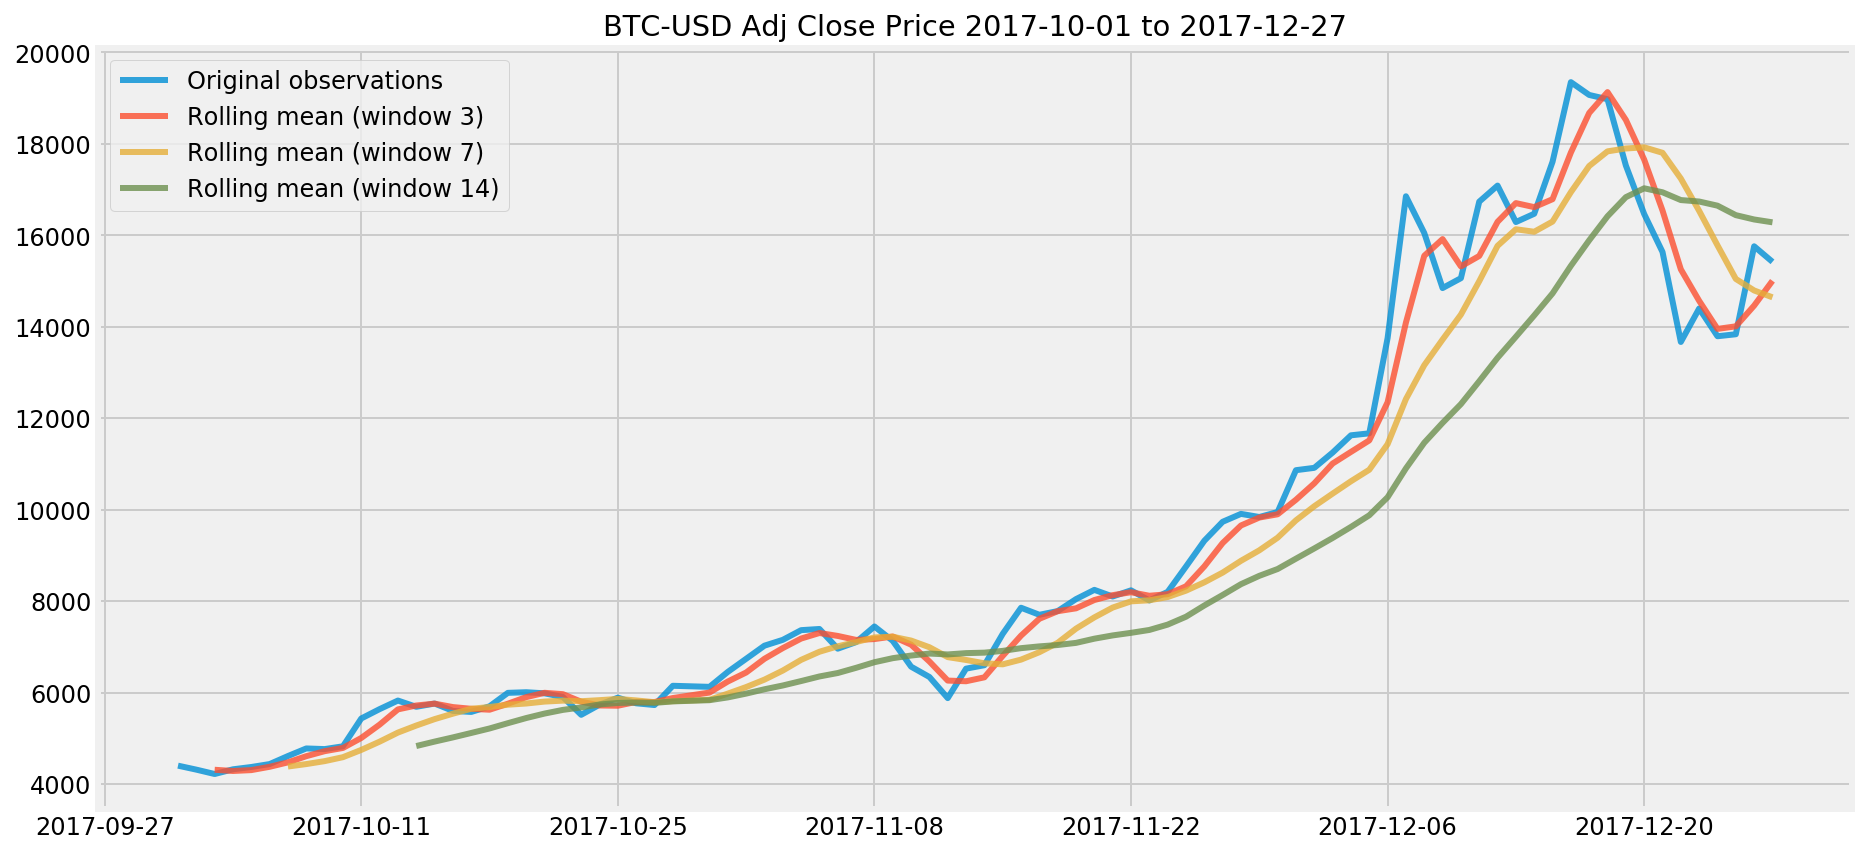

In [8]:
plt.figure(figsize=(14, 7))
plt.plot(btc_recent.index, btc_recent, lw=3, alpha=0.8,label='Original observations')
plt.plot(btc_recent.index, rroll_d3, lw=3, alpha=0.8,label='Rolling mean (window 3)')
plt.plot(btc_recent.index, rroll_d7, lw=3, alpha=0.8,label='Rolling mean (window 7)')
plt.plot(btc_recent.index, rroll_d14, lw=3, alpha=0.8,label='Rolling mean (window 14)')
plt.title('BTC-USD Adj Close Price 2017-10-01 to 2017-12-27')
plt.tick_params(labelsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.show()

Compared to the original observation, which is plotted with a blue line, we can see the curve of the lines get smoother as window sizes get bigger.

## Dual Moving Average Crossover

Another use case of moving average is in a trading strategy called dual moving average crossover. I learned about this through a Medium blog post, and it was very well explained, not only about momentum strategy but also general use case of Python in trading strategy modeling. I highly recommend the post if you are a beginner who's interested in financial modeling with Python.

What I implemented below is just an application of the tutorial from the blog post I mentioned, but I changed to short window to 10 days period rather than 40 days of the original post, and for longer term I used 50 days and named it mid_window instead of using 100 days as the author of the original post did. I guess by changing the time frames shorter, the strategy will be more short-sighted. But I am not a finance expert, and I am not sure if I am making any fundamental mistakes by changing the time frame shorter. If anyone who's reading this is a finance expert, please feel free to correct me if there's any mistake in this logic.

The concept of a dual moving average crossover is fairly straightforward. Calculate two moving averages of the price, one average would be the short term and the other long term. The long term moving average will have a lower variance and will move in the same direction as the short term moving average but at a different rate. The different rates of direction, induces points where the values of the two moving averages may equal and or cross one another. These points are called the crossover points. In the dual moving average crossover trading strategy, these crossovers are points of decision to buy or sell the currencies.

According to the author of the original blog post, "A buy signal is generated when the short-term average crosses the long-term average and rises above it, while a sell signal is triggered by a short-term average crossing long-term average and falling below it".

However, while looking for more material on the subject, I have also found out that there is an opposite approach to the same signal points. The above method introduced by the author is called The Technical Approach and the other approach is called The Value Approach.

"The Value Approach offers the opposite trading signals to the Technical Approach. The Value Approach claims that when the short-term average crosses from below to above the long-term average, that the investment is now overvalued, and should be sold. Conversely when the currency short-term average moves below the long-term average then the currency is undervalued it should be bought".

It is very interesting to see that there are two oppposite way of thinking with same situation. But in this post, I will focus on The Techinical Approach. Now let's see how this can be applied to real data.

In [9]:
short_window = 10
mid_window = 50

signals = pd.DataFrame(index=btc_adj.index)
signals['signal'] = 0.0

roll_d10 = btc_adj.rolling(window=short_window).mean()
roll_d50 = btc_adj.rolling(window=mid_window).mean()

signals['short_mavg'] = roll_d10
signals['mid_mavg'] = roll_d50
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['mid_mavg'][short_window:], 1.0, 0.0)
signals['positions'] = signals['signal'].diff()

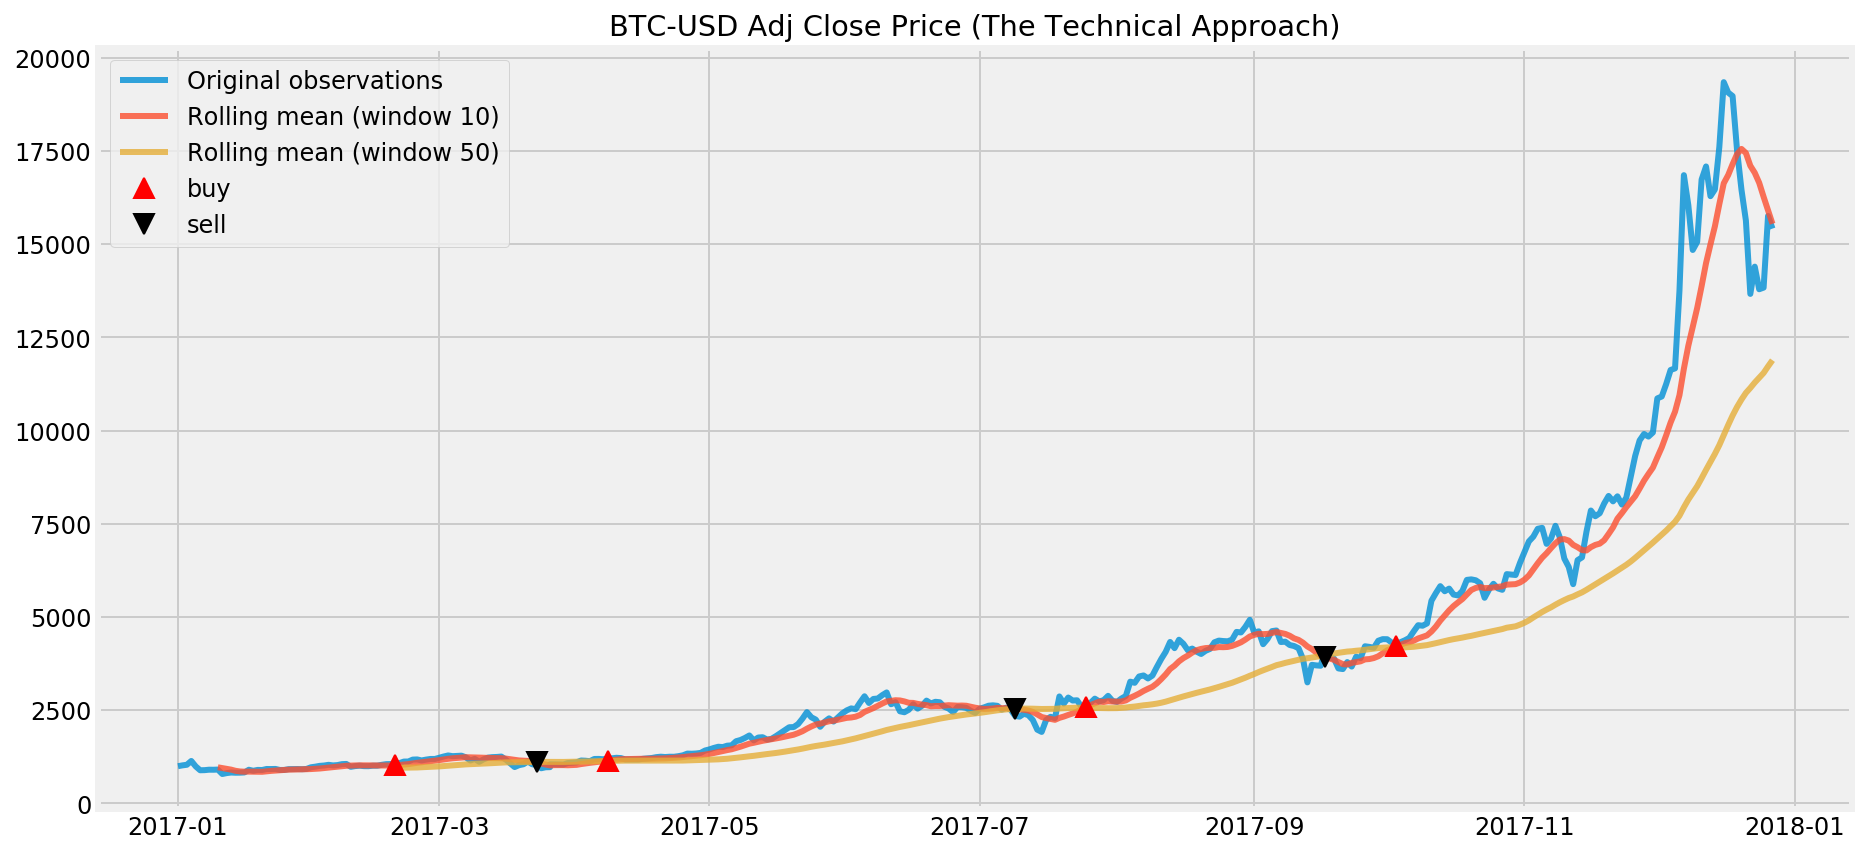

In [10]:
plt.figure(figsize=(14, 7))
plt.plot(btc_adj.index, btc_adj, lw=3, alpha=0.8,label='Original observations')
plt.plot(btc_adj.index, roll_d10, lw=3, alpha=0.8,label='Rolling mean (window 10)')
plt.plot(btc_adj.index, roll_d50, lw=3, alpha=0.8,label='Rolling mean (window 50)')

plt.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='r', label='buy')
         
plt.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='k', label='sell')

plt.title('BTC-USD Adj Close Price (The Technical Approach)')
plt.tick_params(labelsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [12]:
initial_investment = btc_adj.loc[list(signals[signals.positions == 1.0].index)][0]
bought = np.sum(btc_adj.loc[list(signals[signals.positions == 1.0].index)]*-1.0)
sold = np.sum(btc_adj.loc[list(signals[signals.positions == -1.0].index)])
current_value = btc_adj[-1]

balance = pd.DataFrame([btc_adj.loc[list(signals[signals.positions == 1.0].index)]*-1.0,
              btc_adj.loc[list(signals[signals.positions == -1.0].index)]]).transpose()
balance = balance.fillna(0)
balance['balance'] = balance.sum(axis=1)

print "Initial investment amount: {0:.2f} USD".format(initial_investment)
print "Maximum invested amount: {0:.2f} USD".format(abs(min(balance.cumsum().balance)))
print "Current asset value: {0:.2f} USD".format(bought+sold+current_value)

Initial investment amount: 1048.89 USD
Maximum invested amount: 1551.77 USD
Current asset value: 13864.87 USD


With The Techincal Approach, I would have started my investment with 1,048.89 USD, and during the time period of roughly a year, I would have needed 1,551.77 USD to keep investing, and the final value of my 1 Bitcoin would have been valued at 1,3864.87 USD now (27/12/2017). It might be a naive calculation, not taking into account transaction fees or other cost which might have occured. But in a simplified calculation, not a bad investment.

If The Value Approach is applied to the same graph, the situation might not be the same. There are the concepts of "selling short" and "selling long" in finance. "Selling short an asset means selling an asset we do not currently hold and receiving its value in cash. Selling short is different than selling an asset we already own, which is called selling long." To me this always sounds a bit counter intuitive, selling something one doesn't even own. If you are interested in learning more about this, you can find this page from Invesopedia helpful.

From The Technical Approach, the last transaction was "buy", but this in The Value Approach would have been "sell" instead. As you can see the price doesn't fall and keeps going up, and in this case, the short seller may be subject to a margin call from his broker.

## Exponential Moving Average

Another smoothing technique of time series data is EMA (Exponential Moving Average). The EMA is a weighted average of the last n (window size) prices, where the weighting decreases exponentially with each previous price/period.
In simple words, recent prices are given more weight than past prices, and the degree of the contribution exponentially decay as the time period goes further to the past from the current observation.

The (adjusted) exponential moving average for time t is defined as:
$${EMA_t} = \frac{x_t+(1-\alpha)x_{t-1}+(1-\alpha)^2x_{t-2}+...+(1-\alpha)^tx_0}
{1+(1-\alpha)+(1-\alpha)^2+...+(1-\alpha)^t}$$
    

Here alpha is the decaying factor. But there is something I can't understand. I can understand the logic, but when it comes to Pandas' "ewm" function, I couldn't figure out what is the default value of alpha the calculation uses. Maybe there is a standard that everyone agrees even without explicitly stating it, but I have spent a good amount of time trying to figure this out, but I am still not sure. Maybe I'm missing something important. If you are familiar with this, any help would be appreciated.

But intuitively, compared to simple moving average, exponential moving average will react faster to the more recent movement of the price by giving more weights to the current values.

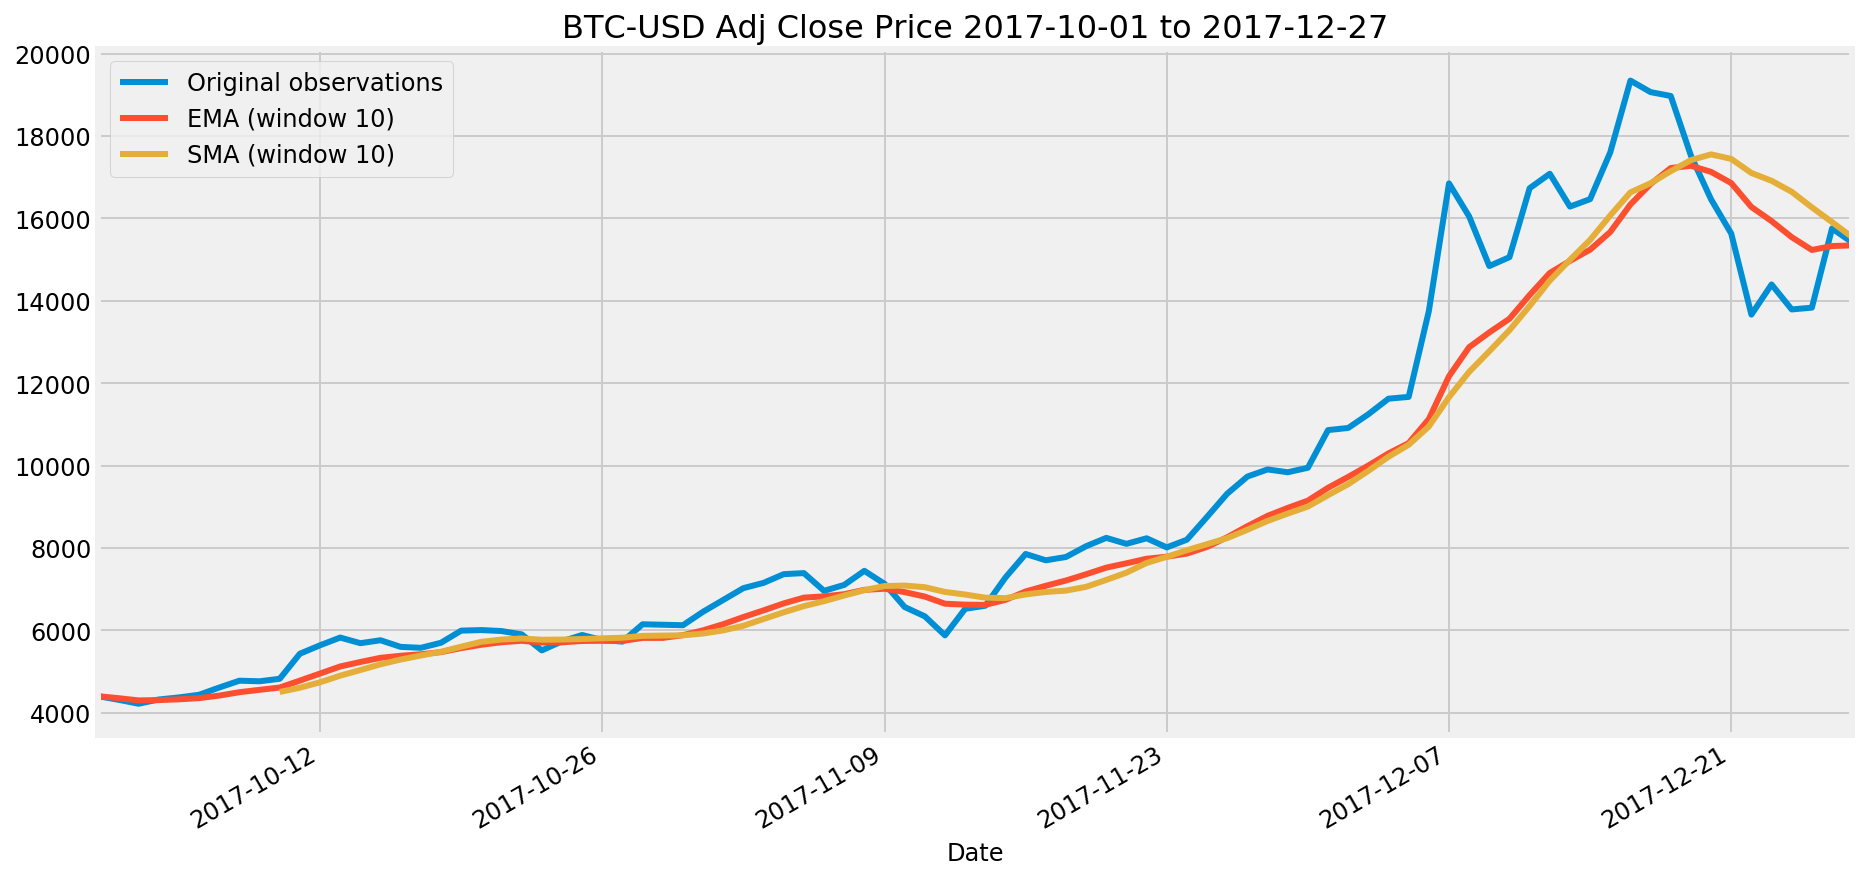

In [13]:
exp_weighted_mean = btc_recent.resample('D').sum().ewm(span=10).mean()
sma_d10 = btc_recent.rolling(window=10).mean()
ax = btc_recent.plot(lw=3, figsize=(14, 7), label='Original observations')
exp_weighted_mean.plot(ax=ax, lw=3, label='EMA (window 10)')
sma_d10.plot(ax=ax, lw=3, label='SMA (window 10)')
plt.title('BTC-USD Adj Close Price 2017-10-01 to 2017-12-27', fontsize=16)
plt.tick_params(labelsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.show()

From the above chart, you can see EMA in red line catches the downwards movement in mid December faster than SMA in yellow line, and also at the very end, EMA started to catch upwards movement, while SMA still showing downwards trend.

You can apply the same logic of Dual Moving Average Crossover to the original observation and EMA. Only this time we look for the crossing points between the original observation and EMA. Let's see how this will perform on a short-time period starting from 01/10/2017 up to 27/12/2017.

In [14]:
exp_weighted_mean = btc_recent.resample('D').sum().ewm(span=20).mean()
signals_ema = pd.DataFrame(index=btc_recent.index)
signals_ema['signal'] = 0.0

signals_ema['original'] = btc_recent
signals_ema['EMA'] = exp_weighted_mean

signals_ema['signal'] = np.where(signals_ema['original'] 
                                            > signals_ema['EMA'], 1.0, 0.0)
signals_ema['positions'] = signals_ema['signal'].diff()

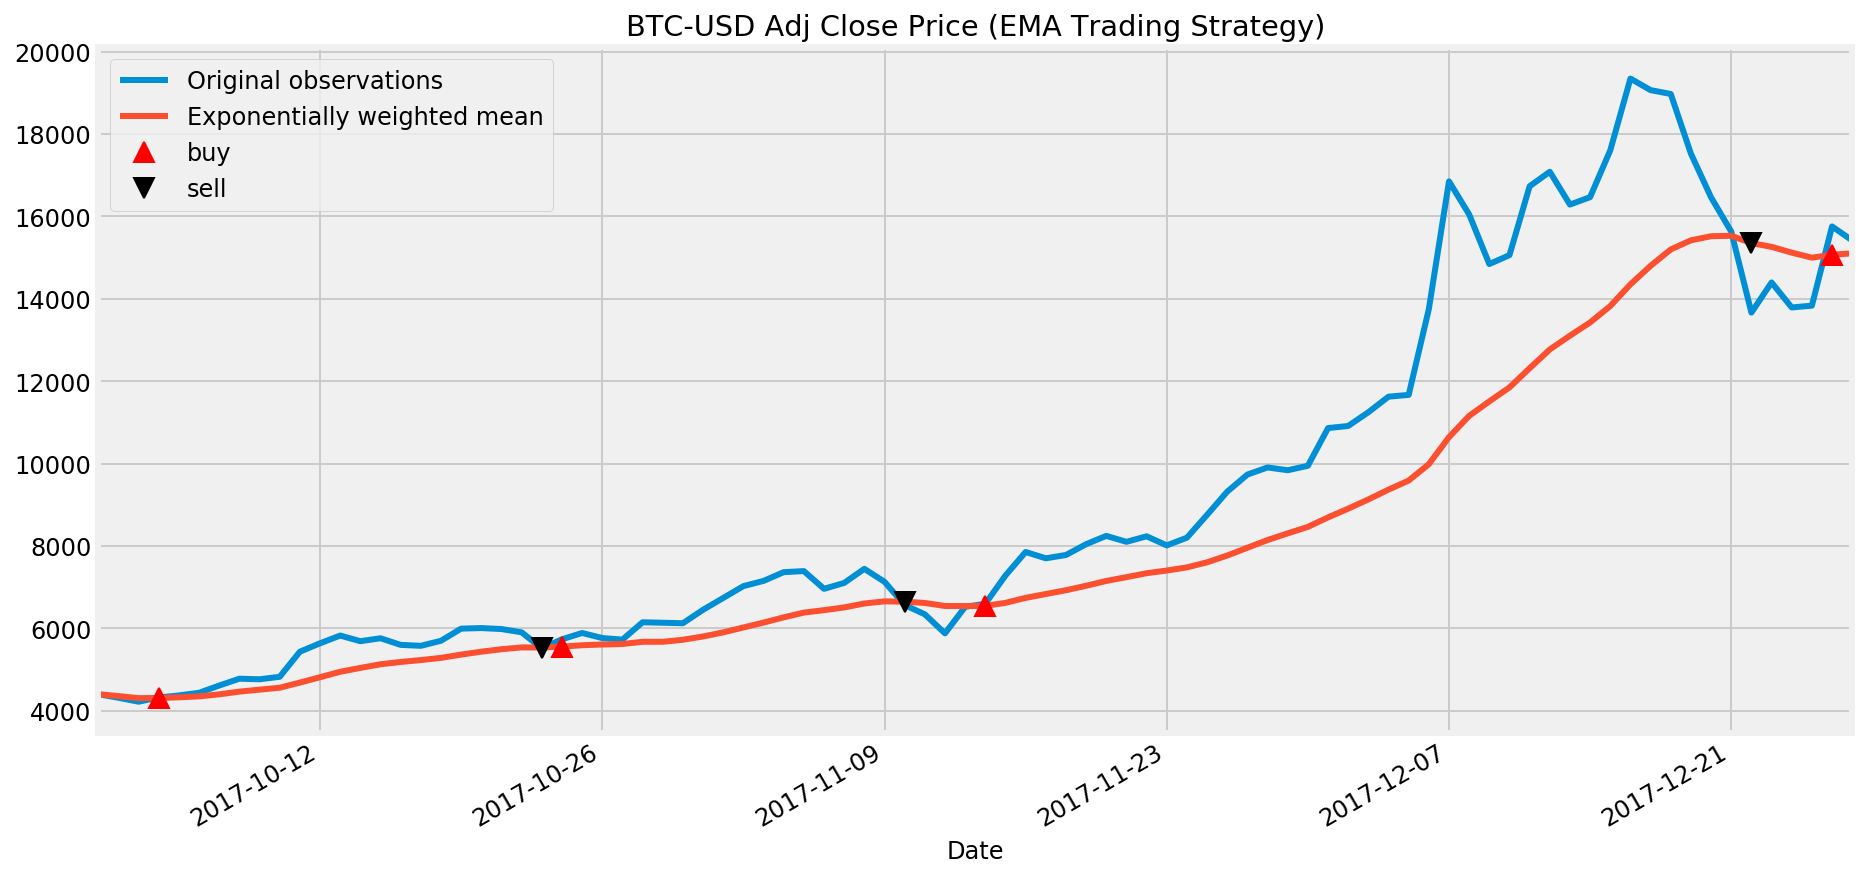

In [15]:
plt.figure(figsize=(14, 7))

ax = btc_recent.plot(lw=3, figsize=(14, 7), label='Original observations')
exp_weighted_mean.plot(ax=ax, lw=3, label='Exponentially weighted mean')

plt.plot(signals_ema.loc[signals_ema.positions == 1.0].index, 
         signals_ema.EMA[signals_ema.positions == 1.0],
         '^', markersize=10, color='r', label='buy')
         
plt.plot(signals_ema.loc[signals_ema.positions == -1.0].index, 
         signals_ema.EMA[signals_ema.positions == -1.0],
         'v', markersize=10, color='k', label='sell')

plt.title('BTC-USD Adj Close Price (EMA Trading Strategy)')
plt.tick_params(labelsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [16]:
initial_investment = btc_recent.loc[list(signals_ema[signals_ema.positions == 1.0].index)][0]
bought = np.sum(btc_recent.loc[list(signals_ema[signals_ema.positions == 1.0].index)]*-1.0)
sold = np.sum(btc_recent.loc[list(signals_ema[signals_ema.positions == -1.0].index)])
current_value = btc_recent[-1]

balance_ema = pd.DataFrame([btc_recent.loc[list(signals_ema[signals_ema.positions == 1.0].index)]*-1.0,
              btc_recent.loc[list(signals_ema[signals_ema.positions == -1.0].index)]]).transpose()
balance_ema = balance_ema.fillna(0)
balance_ema['balance'] = balance_ema.sum(axis=1)

print "Initial investment amount: {0:.2f} USD".format(initial_investment)
print "Maximum invested amount: {0:.2f} USD".format(abs(min(balance_ema.cumsum().balance)))
print "Current asset value: {0:.2f} USD".format(bought+sold+current_value)

Initial investment amount: 4321.44 USD
Maximum invested amount: 6665.21 USD
Current asset value: 8751.43 USD


With EMA trading strategy, I would have started my investment with 4,321.44 USD, and during the time period of roughly two months, I would have needed 6,665.21 USD to keep investing, and the final value of my 1 Bitcoin would have been valued at 8,751.43 USD now (27/12/2017).